In [0]:
 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils import  np_utils
from keras.initializers import glorot_uniform
import pandas as pd
from keras.layers.merge import Concatenate, add
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
import matplotlib.pyplot as plt
import keras.preprocessing.image as prep
from IPython.display import SVG
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from keras.optimizers import Adam


Using TensorFlow backend.


In [0]:
data =  pd.read_json('/content/drive/My Drive/kaggle/data/train/train.json')
test =   pd.read_json('/content/drive/My Drive/kaggle/data/test/test.json')

In [0]:


X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_1"]])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])
channel_3 = X_band_1 + X_band_2
new_data = np.concatenate([X_band_1[:, :, :, np.newaxis],
                             X_band_2[:, :, :, np.newaxis],
                             channel_3[:, :, :, np.newaxis]], axis=-1)

targets = data["is_iceberg"]

split = np.array_split(new_data, 10, axis=0)
X_train = np.concatenate(split[0:8], axis=0)
X_test = np.concatenate(split[8:10], axis=0)
Y_train = np.concatenate(np.array_split(targets, 10, axis=0)[0:8], axis=0)
Y_test = np.concatenate(np.array_split(targets, 10, axis=0)[8:10], axis=0)

y_train = np_utils.to_categorical(Y_train, num_classes=2)
y_test = np_utils.to_categorical(Y_test, num_classes=2)

In [0]:
# image generator generating image tensors from the data
gen = prep.ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=2,
                         height_shift_range=2,
                         channel_shift_range=0,
                         zoom_range=0.2,
                         rotation_range=10)

gen_op = gen.flow(x=X_train, y=y_train, seed=10)
gen_val = gen.flow(x=X_test, y=y_test, seed=10)

In [0]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2 = filters

    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    

    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):
     
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

    X_shortcut = Conv2D(filters=F2, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)


    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [0]:
def ResNet50(input_shape, classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 128], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 128], stage=2, block='b')

    X = convolutional_block(X, f=3, filters=[128, 256], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 256], stage=3, block='b')

    X = convolutional_block(X, f=3, filters=[256, 512], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 512], stage=4, block='b')


    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [0]:

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       patience=7,
                                       verbose=0,
                                       epsilon=1e-4,
                                       mode='min')
    return [es, msave,reduce_lr_loss]

In [0]:
file_path = ".resnet50_weights_tf_dim_ordering_tf_kernels.h5"
callbacks = get_callbacks(filepath=file_path, patience=5)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
gmodel = ResNet50(input_shape=(75, 75, 3), classes=2)














Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 81, 81, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 38, 38, 64)   256         conv1[0][0]                      
______________________________________________________________________________

In [0]:
for i,layer in enumerate(gmodel.layers):
    print(i,layer.name)

0 input_1
1 zero_padding2d_1
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 res2a_branch1
11 bn2a_branch2b
12 bn2a_branch1
13 add_1
14 activation_3
15 res2b_branch2a
16 bn2b_branch2a
17 activation_4
18 res2b_branch2b
19 bn2b_branch2b
20 add_2
21 activation_5
22 res3a_branch2a
23 bn3a_branch2a
24 activation_6
25 res3a_branch2b
26 res3a_branch1
27 bn3a_branch2b
28 bn3a_branch1
29 add_3
30 activation_7
31 res3b_branch2a
32 bn3b_branch2a
33 activation_8
34 res3b_branch2b
35 bn3b_branch2b
36 add_4
37 activation_9
38 res4a_branch2a
39 bn4a_branch2a
40 activation_10
41 res4a_branch2b
42 res4a_branch1
43 bn4a_branch2b
44 bn4a_branch1
45 add_5
46 activation_11
47 res4b_branch2a
48 bn4b_branch2a
49 activation_12
50 res4b_branch2b
51 bn4b_branch2b
52 add_6
53 activation_13
54 average_pooling2d_1
55 flatten_1
56 fc2


In [0]:
history = gmodel.fit_generator(generator=gen_op,
                    epochs=20,
                    validation_data=gen_val,
                    callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
41/41 [==============================] - 77s 2s/step - loss: 1.0727 - acc: 0.6568 - val_loss: 0.6375 - val_acc: 0.6125
Epoch 2/20
41/41 [==============================] - 73s 2s/step - loss: 0.6560 - acc: 0.6884 - val_loss: 0.5320 - val_acc: 0.7188
Epoch 3/20
41/41 [==============================] - 70s 2s/step - loss: 0.4766 - acc: 0.7834 - val_loss: 0.4584 - val_acc: 0.7188
Epoch 4/20
41/41 [==============================] - 65s 2s/step - loss: 0.4171 - acc: 0.8177 - val_loss: 0.4546 - val_acc: 0.7312
Epoch 5/20
41/41 [==============================] - 75s 2s/step - loss: 0.4321 - acc: 0.8104 - val_loss: 0.4537 - val_acc: 0.7937
Epoch 6/20
41/41 [==============================] - 75s 2s/step - loss: 0.4039 - acc: 0.8101 - val_loss: 0.4356 - val_acc: 0.8094
Epoch 7/20
41/41 [==============================] - 89s 2s/step - loss: 0.3791 - acc: 0.8316 - val_loss: 0.6787 - val_acc: 0

In [0]:

gmodel.load_weights(file_path)
score = gmodel.evaluate(X_test,y_test, verbose=1)
print('validation loss:', score[0])
print('validation accuracy:', score[1]*100)

320/320 [==============================] - 3s 11ms/step
validation loss: 0.3103029400110245
validation accuracy: 87.8125


In [0]:
score = gmodel.evaluate(gen_op, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1]*100)

41/41 [==============================] - 15s 378ms/step
Train loss: 0.25671795645374745
Train accuracy: 89.56386292834891


In [0]:
def plot_history(history):
    # history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
def plot_confusion_matrix(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cnf_matrix, square=True, cmap='RdYlGn')
    plt.show()

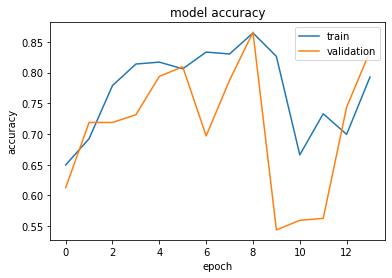

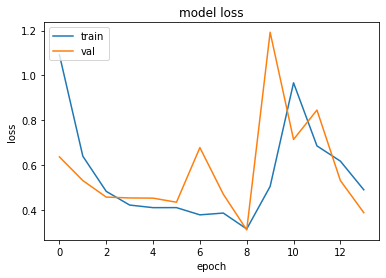

In [0]:

plot_history(history)

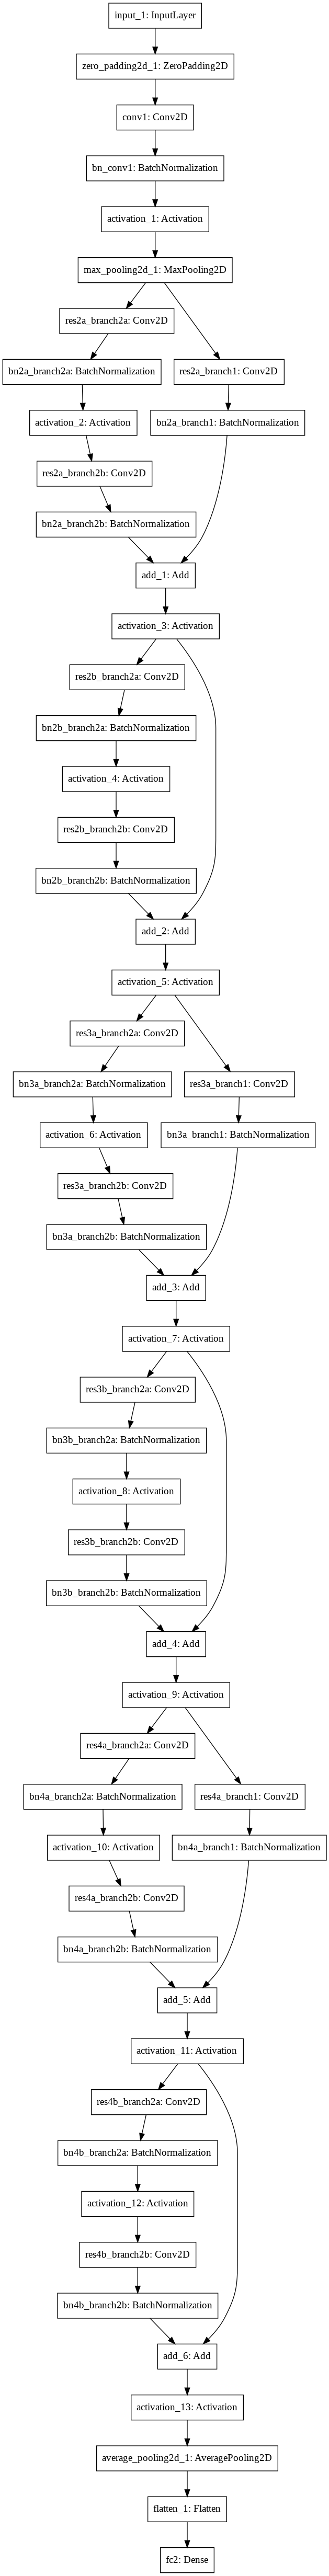

In [0]:
plot_model(gmodel)

In [0]:
predictions = gmodel.predict(X_test, batch_size=10)
y_pred = np.argmax(predictions, axis=1)

In [0]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.78      0.83       211
           1       0.66      0.83      0.73       109

    accuracy                           0.79       320
   macro avg       0.78      0.80      0.78       320
weighted avg       0.81      0.79      0.80       320



In [0]:
confusion_matrix(Y_test,y_pred)

array([[164,  47],
       [ 19,  90]])

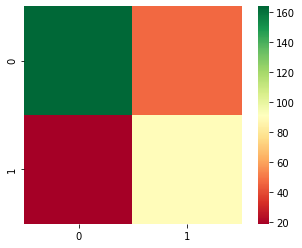

In [0]:
plot_confusion_matrix(Y_test,y_pred)